In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import squeezenet1_1, resnet18
from torchvision.models.squeezenet import SqueezeNet1_1_Weights
from torchvision.models.resnet import ResNet18_Weights

import pandas as pd
import numpy as np
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import itertools
from tqdm import tqdm
import pickle
import gc
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
class MIDmodel(nn.Module):
    def __init__(self):
        super(MIDmodel, self).__init__()
        self.pretrained = squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)
        self.fc1 = nn.Linear(1000, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
class MIDmodel2(nn.Module):
    def __init__(self):
        super(MIDmodel2, self).__init__()
        self.pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)
        # remove the last fully connected layer
        self.pretrained.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 4)

    def get_embeddings(self, x):
        x = self.pretrained(x)
        return x

    def forward(self, x):
        x = self.pretrained(x)
        x = self.fc1(x)
        return x

In [8]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, patients_ids, patients_df, transform=None):
        self.patients_df = patients_df[patients_df["patient_id"].isin(patients_ids)]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.patients_df)

    def __getitem__(self, idx):
        row = self.patients_df.iloc[idx]
        # path = root_dir/patientid_examid_spot_framenumber_score.png
        path = os.path.join(self.root_dir, row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")
        image = Image.open(path)
        label = row["score"]

        if self.transform:
            image = self.transform(image)
            
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224))(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, int(label), path

['1017', '1052', '1067', '1050', '1069', '1047', '1048', '1051']
score
0    7888
1    7540
2    7189
3    7592
Name: patient_id, dtype: int64
['1066', '1045', '1068']
score
0    6625
1    1721
2    5535
3    3631
Name: patient_id, dtype: int64
Plot of the std of the 8-patient combinations:


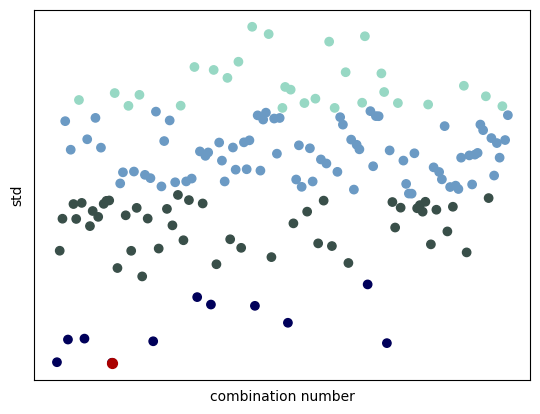

Plot of the number of frames for each score:


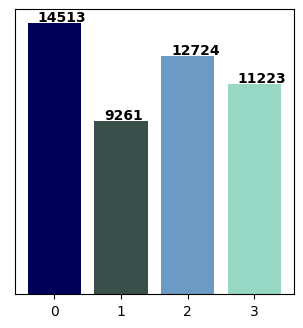

Plot of the number of frames for each score in the training set:


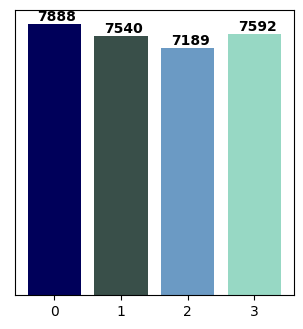

Plot of the number of frames for each score in the test set:


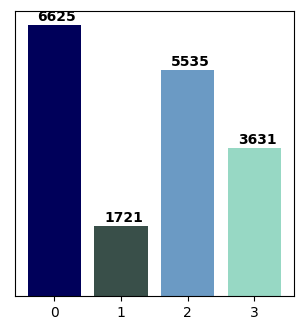

Plot of the number of frames for each patient by score:


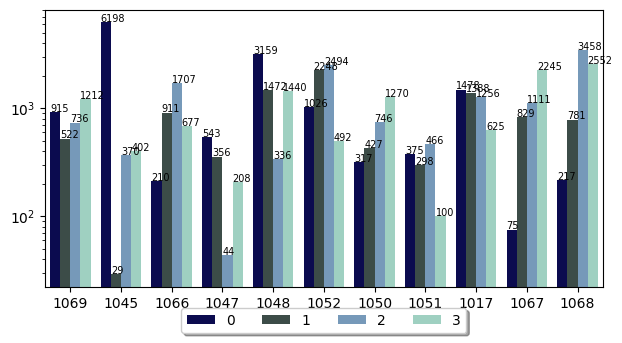

Plot of the number of frames for each spot by score:


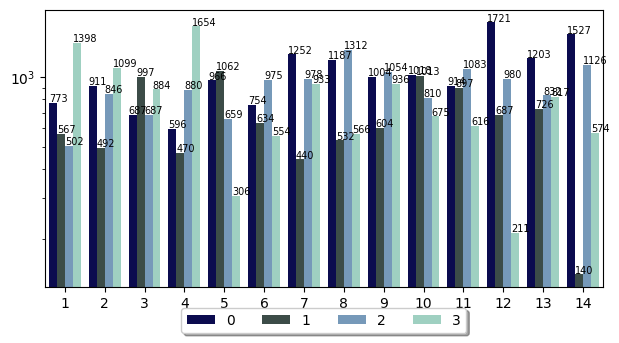

Plot of the number of frames for each spot by score for the training patients:


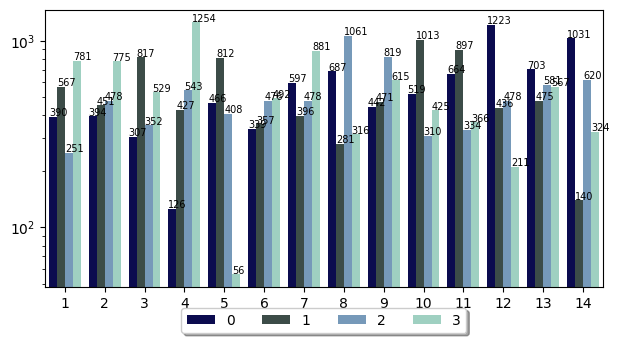

Plot of the number of frames for each spot by score for the test patients:


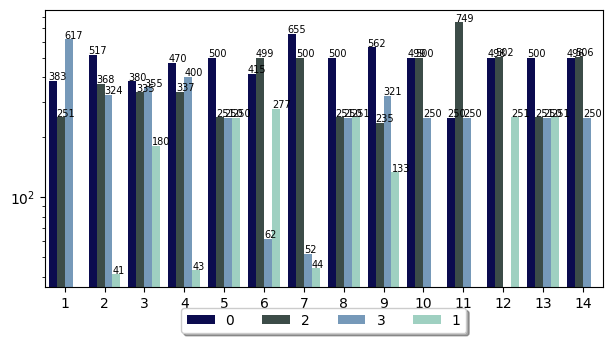

In [2]:
data_dir = "images/"
images_paths = glob.glob(f"{data_dir}*.png", recursive=True)
images_df = pd.DataFrame([path[len(data_dir):-4].split("_") for path in images_paths], columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
images_df["score"] = images_df["score"].astype(str)
images_df["frame_number"] = images_df["frame_number"].astype(str)
images_df["spot"] = images_df["spot"].astype(str)
images_df["patient_id"] = images_df["patient_id"].astype(str)
images_df["exam_id"] = images_df["exam_id"].astype(str)
patients_ids = set(images_df["patient_id"])
patients_ids = list(patients_ids)

# select the 8 patients for training based on the most balanced distribution of the scores
combs = list(itertools.combinations(patients_ids, 8))
stds = []
for i, c in enumerate(combs):
    stds.append((images_df[images_df["patient_id"].isin(c)].groupby("score").count()["patient_id"].std(), i))
# sort the stds
train_patients = [x for x in combs[min(stds)[1]]]
print(train_patients)
print(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"])
test_patients = [x for x in patients_ids if x not in train_patients]
print(test_patients)
print(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"])


# plot of the std of the 8-patient combinations
custom_cmap = ListedColormap(["#00005A", "#394F49", "#6B9AC4", "#97D8C4"])
plt.scatter(np.arange(len(stds)), [x[0] for x in stds], c=[x[0] for x in stds], cmap=custom_cmap)
plt.scatter(stds[min(stds)[1]][1], stds[min(stds)[1]][0], c="#AA0000", s=50)
plt.xticks([])
plt.yticks([])
plt.xlabel("combination number")
plt.ylabel("std")
print("Plot of the std of the 8-patient combinations:")
plt.show()

colors =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]

logs = np.log(images_df.groupby("score").count()["patient_id"])
plt.bar(images_df.groupby("score").count().index, images_df.groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df.groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score:")
plt.show()

#plot the number of frames for each score in the training set
plt.bar(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count().index, images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score in the training set:")
plt.show()

#plot the number of frames for each score in the test set
plt.bar(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count().index, images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score in the test set:")
plt.show()

# plot the number of images for each patient by score
plt.figure(figsize=(20,10))
# copy images_df in a new df called images_df3
images_df2 = images_df.copy()
images_df2 = images_df2.sort_values(by=["score"])
plt.yscale("log")
ax = sns.countplot(x="patient_id", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each patient by score:")
plt.show()

# now number of images per spot per score
plt.figure(figsize=(20,10))
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score:")
plt.show()

# filter images_df to only contain the training patients
images_df2 = images_df.copy()
images_df2 = images_df2[images_df["patient_id"].isin(train_patients)]
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score for the training patients:")
plt.show()

# filter images_df to only contain the test patients
images_df2 = images_df.copy()
images_df2 = images_df2[images_df["patient_id"].isin(test_patients)]
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score for the test patients:")
plt.show()


In [10]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects/ len(dataloader.dataset)
    return epoch_loss, epoch_acc

def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [43]:
data_dir = "images/"
num_epochs = 16
learning_rate = 0.00001
batch_size = 8

transformations = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0, 0.15), scale=(0.55, 1.45), shear=4.5)], p=1/2),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.45, contrast=0.45, saturation=0.45, hue=0.45)], p=1/2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.75))], p=1/2),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=1/2),
    ])

model = MIDmodel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_dataset = ImageDataset(data_dir, train_patients, images_df, transformations)

test_images_df = images_df[images_df["patient_id"].isin(test_patients)]
# get only 800 images per score in the test set to have a balanced test set and speed up the training
test_images_df = test_images_df.groupby("score").apply(lambda x: x.sample(800)).reset_index(drop=True)
# test_dataset = ImageDataset(data_dir, test_patients, test_images_df)
test_dataset = ImageDataset(data_dir, test_patients, images_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
results_train = []
results_test = []

best_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/MIDmodel.pt")

best_acc1 = best_acc
torch.save(model.state_dict(), f"models/MIDmodel_last.pt")

Epoch 0


  0%|          | 3/3777 [00:01<21:51,  2.88it/s]


KeyboardInterrupt: 

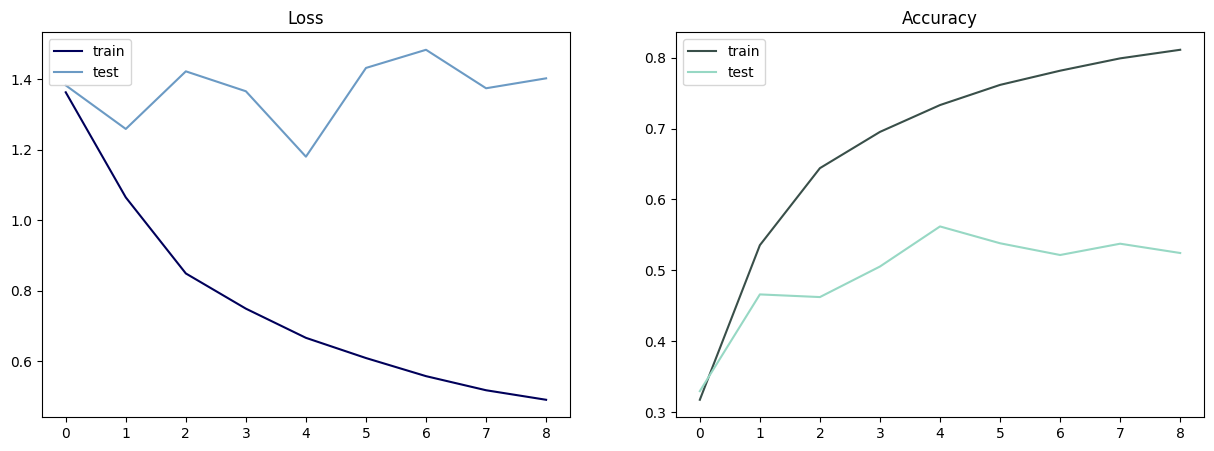

4


In [ ]:
results_testA = [[x[0], x[1].item()] for x in results_test]
results_trainA = [[x[0], x[1].item()] for x in results_train]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
colors =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]
ax[0].plot(np.array(results_trainA)[:, 0], label="train", color=colors[0])
ax[0].plot(np.array(results_testA)[:, 0], label="test", color=colors[2])
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(np.array(results_trainA)[:, 1], label="train", color=colors[1])
ax[1].plot(np.array(results_testA)[:, 1], label="test", color=colors[3])
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

# print the i where  test loss is minimized
print(np.argmin(np.array(results_testA)[:, 0]))

100%|██████████| 400/400 [00:36<00:00, 10.87it/s]


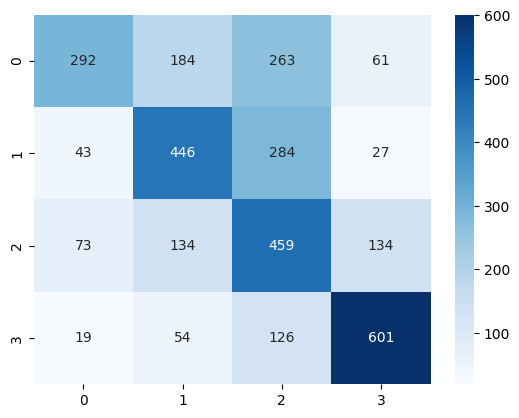

In [ ]:
model = MIDmodel()
model.load_state_dict(torch.load("models/MIDmodel.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()



In [ ]:
model = MIDmodel2()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
results_train = []
results_test = []
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    # if current test accuracy is better than previous best, save the model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/MIDmodel2.pt")
best_acc2 = best_acc
torch.save(model.state_dict(), f"models/MIDmodel2_last.pt")


Epoch 0


100%|██████████| 3777/3777 [20:08<00:00,  3.13it/s]


Training Loss: 0.7485 Training Accuracy: 0.6984


100%|██████████| 400/400 [00:39<00:00, 10.25it/s]


Test Loss: 1.3264 Test Accuracy: 0.5188
Epoch 1


100%|██████████| 3777/3777 [19:46<00:00,  3.18it/s]


Training Loss: 0.4539 Training Accuracy: 0.8295


100%|██████████| 400/400 [00:39<00:00, 10.22it/s]


Test Loss: 1.1518 Test Accuracy: 0.6031
Epoch 2


100%|██████████| 3777/3777 [19:39<00:00,  3.20it/s]


Training Loss: 0.3582 Training Accuracy: 0.8677


100%|██████████| 400/400 [00:39<00:00, 10.02it/s]


Test Loss: 1.3211 Test Accuracy: 0.5428
Epoch 3


100%|██████████| 3777/3777 [19:49<00:00,  3.17it/s]


Training Loss: 0.3038 Training Accuracy: 0.8887


100%|██████████| 400/400 [00:39<00:00, 10.05it/s]


Test Loss: 1.3771 Test Accuracy: 0.5550
Epoch 4


100%|██████████| 3777/3777 [19:53<00:00,  3.16it/s]


Training Loss: 0.2715 Training Accuracy: 0.9007


100%|██████████| 400/400 [00:40<00:00,  9.91it/s]


Test Loss: 1.3991 Test Accuracy: 0.5334
Epoch 5


100%|██████████| 3777/3777 [19:44<00:00,  3.19it/s]


Training Loss: 0.2444 Training Accuracy: 0.9112


100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Test Loss: 1.6543 Test Accuracy: 0.5316
Epoch 6


100%|██████████| 3777/3777 [19:29<00:00,  3.23it/s]


Training Loss: 0.2221 Training Accuracy: 0.9200


100%|██████████| 400/400 [00:44<00:00,  9.00it/s]


Test Loss: 1.5222 Test Accuracy: 0.5644
Epoch 7


100%|██████████| 3777/3777 [19:31<00:00,  3.22it/s]


Training Loss: 0.2075 Training Accuracy: 0.9254


100%|██████████| 400/400 [00:43<00:00,  9.15it/s]


Test Loss: 1.5660 Test Accuracy: 0.5353
Epoch 8


100%|██████████| 3777/3777 [19:30<00:00,  3.23it/s]


Training Loss: 0.1893 Training Accuracy: 0.9313


100%|██████████| 400/400 [00:39<00:00, 10.11it/s]


Test Loss: 1.4173 Test Accuracy: 0.5662
Epoch 9


100%|██████████| 3777/3777 [19:33<00:00,  3.22it/s]


Training Loss: 0.1779 Training Accuracy: 0.9361


100%|██████████| 400/400 [00:43<00:00,  9.19it/s]


Test Loss: 1.6126 Test Accuracy: 0.5619
Epoch 10


100%|██████████| 3777/3777 [19:35<00:00,  3.21it/s]


Training Loss: 0.1665 Training Accuracy: 0.9387


100%|██████████| 400/400 [00:43<00:00,  9.11it/s]


Test Loss: 1.7252 Test Accuracy: 0.5147
Epoch 11


100%|██████████| 3777/3777 [19:39<00:00,  3.20it/s]


Training Loss: 0.1543 Training Accuracy: 0.9437


100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


Test Loss: 1.6628 Test Accuracy: 0.5372
Epoch 12


100%|██████████| 3777/3777 [19:32<00:00,  3.22it/s]


Training Loss: 0.1543 Training Accuracy: 0.9421


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Test Loss: 1.9398 Test Accuracy: 0.5241
Epoch 13


  2%|▏         | 75/3777 [00:23<19:08,  3.22it/s]


KeyboardInterrupt: 

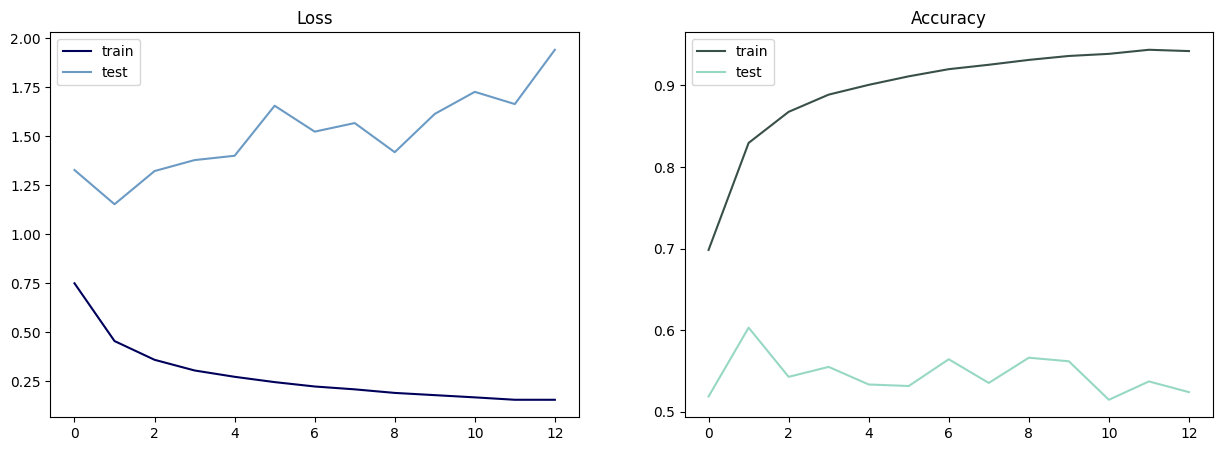

1


100%|██████████| 400/400 [00:38<00:00, 10.45it/s]


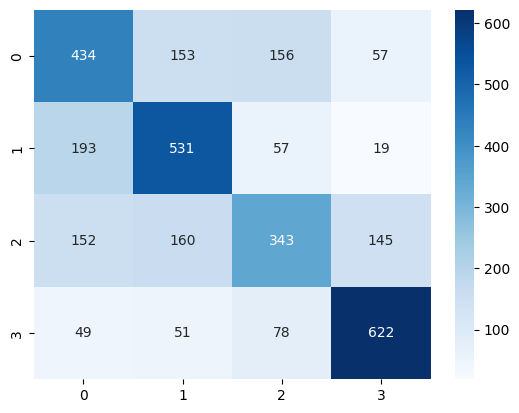

In [ ]:
results_testA = [[x[0], x[1].item()] for x in results_test]
results_trainA = [[x[0], x[1].item()] for x in results_train]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(results_trainA)[:, 0], label="train", color=colors[0])
ax[0].plot(np.array(results_testA)[:, 0], label="test", color=colors[2])
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(np.array(results_trainA)[:, 1], label="train", color=colors[1])
ax[1].plot(np.array(results_testA)[:, 1], label="test", color=colors[3])
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

# print the i where  test loss is minimized
print(np.argmin(np.array(results_testA)[:, 0]))

model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

100%|██████████| 2189/2189 [03:38<00:00, 10.00it/s]

Accuracy:  0.563270899954317


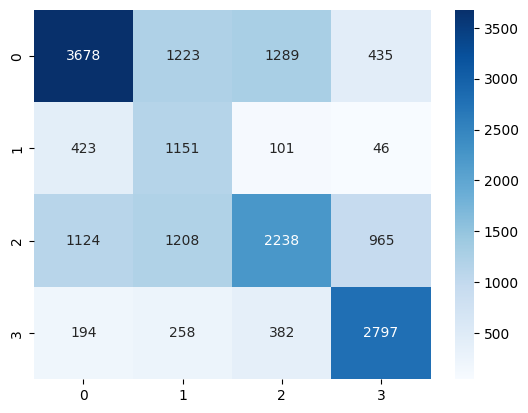

In [44]:
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy: ", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

Classifier to predict if the confidence is high enough, created on the train dataset

In [ ]:
# load the last model
best_acc1 = 0.5619
best_acc2 = 0.6031
if best_acc1 > best_acc2:
    print("Loaded MIDmodel.pt")
    model = MIDmodel()
    model.load_state_dict(torch.load("models/MIDmodel.pt"))
else:
    print("Loaded MIDmodel2.pt")
    model = MIDmodel2()
    model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

test_dataset = ImageDataset(data_dir, test_patients, images_df)

correct_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])
wrong_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])

for i in tqdm(range(len(test_dataset))):
    img, label, path = test_dataset[i]
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    sm = nn.Softmax(dim=1)
    sm = sm(output)
    sm = sm.cpu().detach().numpy()
    sm = sm[0]
    if torch.argmax(output) == label:
        correct_preds = pd.concat([correct_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])
    else:
        wrong_preds = pd.concat([wrong_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])

correct_preds.to_csv("data/correct_preds_test.csv", index=False)
wrong_preds.to_csv("data/wrong_preds_test.csv", index=False)


Loaded MIDmodel2.pt


100%|██████████| 17512/17512 [05:15<00:00, 55.47it/s]


In [ ]:
correct_preds = pd.read_csv("data/correct_preds_test.csv")
wrong_preds = pd.read_csv("data/wrong_preds_test.csv")

correct_preds["correct"] = 1
wrong_preds["correct"] = 0

preds_total = pd.concat([correct_preds, wrong_preds])
preds_total.to_csv("data/values_test.csv", index=False)

DL model to binary classify images

In [18]:
class MIDbinary(nn.Module):
    def __init__(self):
        super(MIDbinary, self).__init__()
        self.fc1 = nn.Linear(4, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x
    
class BinaryDataset(Dataset):
    def __init__(self, preds):
        self.preds = preds

    def __len__(self):
        return len(self.preds)

    def __getitem__(self, idx):
        label = self.preds.iloc[idx]["correct"]
        sms = self.preds.iloc[idx][["sm0", "sm1", "sm2", "sm3"]]
        sms = torch.tensor(list(sms.values), dtype=torch.float32)
        return sms, int(label), self.preds.iloc[idx]["path"]

Epoch 0


100%|██████████| 3777/3777 [00:18<00:00, 209.41it/s]


Training Loss: 0.7073 Training Accuracy: 0.3764


100%|██████████| 2189/2189 [00:08<00:00, 256.62it/s]


Test Loss: 0.6959 Test Accuracy: 0.5277
Epoch 1


100%|██████████| 3777/3777 [00:16<00:00, 224.89it/s]


Training Loss: 0.7031 Training Accuracy: 0.5064


100%|██████████| 2189/2189 [00:08<00:00, 260.04it/s]


Test Loss: 0.6953 Test Accuracy: 0.5444
Epoch 2


100%|██████████| 3777/3777 [00:16<00:00, 222.48it/s]


Training Loss: 0.7003 Training Accuracy: 0.5122


100%|██████████| 2189/2189 [00:08<00:00, 246.76it/s]


Test Loss: 0.6947 Test Accuracy: 0.5467
Epoch 3


100%|██████████| 3777/3777 [00:17<00:00, 221.66it/s]


Training Loss: 0.6982 Training Accuracy: 0.5083


100%|██████████| 2189/2189 [00:08<00:00, 257.79it/s]


Test Loss: 0.6944 Test Accuracy: 0.5450
Epoch 4


100%|██████████| 3777/3777 [00:16<00:00, 233.03it/s]


Training Loss: 0.6968 Training Accuracy: 0.5098


100%|██████████| 2189/2189 [00:08<00:00, 261.44it/s]


Test Loss: 0.6941 Test Accuracy: 0.5426
Epoch 5


100%|██████████| 3777/3777 [00:16<00:00, 231.98it/s]


Training Loss: 0.6958 Training Accuracy: 0.5127


100%|██████████| 2189/2189 [00:08<00:00, 263.03it/s]


Test Loss: 0.6939 Test Accuracy: 0.5399
Epoch 6


100%|██████████| 3777/3777 [00:15<00:00, 237.31it/s]


Training Loss: 0.6951 Training Accuracy: 0.5155


100%|██████████| 2189/2189 [00:08<00:00, 263.98it/s]


Test Loss: 0.6938 Test Accuracy: 0.5361
Epoch 7


100%|██████████| 3777/3777 [00:16<00:00, 224.00it/s]


Training Loss: 0.6946 Training Accuracy: 0.5184


100%|██████████| 2189/2189 [00:08<00:00, 258.33it/s]


Test Loss: 0.6937 Test Accuracy: 0.5349
Epoch 8


100%|██████████| 3777/3777 [00:16<00:00, 232.14it/s]


Training Loss: 0.6943 Training Accuracy: 0.5211


100%|██████████| 2189/2189 [00:08<00:00, 259.54it/s]


Test Loss: 0.6936 Test Accuracy: 0.5330
Epoch 9


100%|██████████| 3777/3777 [00:16<00:00, 228.79it/s]


Training Loss: 0.6940 Training Accuracy: 0.5222


100%|██████████| 2189/2189 [00:08<00:00, 261.17it/s]


Test Loss: 0.6936 Test Accuracy: 0.5313
Epoch 10


100%|██████████| 3777/3777 [00:16<00:00, 226.85it/s]


Training Loss: 0.6939 Training Accuracy: 0.5233


100%|██████████| 2189/2189 [00:07<00:00, 279.24it/s]


Test Loss: 0.6936 Test Accuracy: 0.5302
Epoch 11


100%|██████████| 3777/3777 [00:17<00:00, 220.74it/s]


Training Loss: 0.6937 Training Accuracy: 0.5236


100%|██████████| 2189/2189 [00:07<00:00, 294.85it/s]


Test Loss: 0.6935 Test Accuracy: 0.5299
Epoch 12


100%|██████████| 3777/3777 [00:17<00:00, 220.95it/s]


Training Loss: 0.6937 Training Accuracy: 0.5243


100%|██████████| 2189/2189 [00:08<00:00, 272.07it/s]


Test Loss: 0.6935 Test Accuracy: 0.5297
Epoch 13


100%|██████████| 3777/3777 [00:15<00:00, 238.65it/s]


Training Loss: 0.6936 Training Accuracy: 0.5247


100%|██████████| 2189/2189 [00:08<00:00, 266.98it/s]


Test Loss: 0.6935 Test Accuracy: 0.5291
Epoch 14


100%|██████████| 3777/3777 [00:16<00:00, 228.21it/s]


Training Loss: 0.6936 Training Accuracy: 0.5250


100%|██████████| 2189/2189 [00:08<00:00, 267.33it/s]


Test Loss: 0.6935 Test Accuracy: 0.5288
Epoch 15


100%|██████████| 3777/3777 [00:16<00:00, 229.56it/s]


Training Loss: 0.6935 Training Accuracy: 0.5251


100%|██████████| 2189/2189 [00:08<00:00, 259.54it/s]


Test Loss: 0.6935 Test Accuracy: 0.5284
Epoch 16


100%|██████████| 3777/3777 [00:16<00:00, 225.39it/s]


Training Loss: 0.6935 Training Accuracy: 0.5252


100%|██████████| 2189/2189 [00:08<00:00, 258.90it/s]


Test Loss: 0.6935 Test Accuracy: 0.5287
Epoch 17


100%|██████████| 3777/3777 [00:16<00:00, 224.39it/s]


Training Loss: 0.6935 Training Accuracy: 0.5253


100%|██████████| 2189/2189 [00:08<00:00, 257.57it/s]


Test Loss: 0.6935 Test Accuracy: 0.5287
Epoch 18


100%|██████████| 3777/3777 [00:16<00:00, 227.18it/s]


Training Loss: 0.6935 Training Accuracy: 0.5253


100%|██████████| 2189/2189 [00:08<00:00, 253.29it/s]


Test Loss: 0.6935 Test Accuracy: 0.5287
Epoch 19


100%|██████████| 3777/3777 [00:16<00:00, 229.74it/s]


Training Loss: 0.6935 Training Accuracy: 0.5253


100%|██████████| 2189/2189 [00:08<00:00, 261.65it/s]


Test Loss: 0.6935 Test Accuracy: 0.5288
Train:  [[0.7073040906195726, 0.3764110207557678], [0.7030500564671797, 0.5064384937286377], [0.7002637795281428, 0.5121652483940125], [0.698194443739539, 0.508259117603302], [0.6968271173279045, 0.5098480582237244], [0.6958069317927013, 0.5126618146896362], [0.6951300386497149, 0.5155417323112488], [0.6946236874295693, 0.518388569355011], [0.6942869297319793, 0.5210698843002319], [0.6940346889207938, 0.522228479385376], [0.6938667918842675, 0.5232546925544739], [0.6937411187058855, 0.5235856771469116], [0.6936576631566478, 0.5243139863014221], [0.6935948414770035, 0.5247111916542053], [0.6935528189238838, 0.5249760150909424], [0.6935216047513717, 0.5250753164291382], [0.6935013025972433, 0.5252077579498291], [0.6934862039686571, 0.5253401398658752], [0.6934762707201402, 0.5253070592880249], [0.6934688023206963, 0.5253070592880249]]
Test:  [[0.6959041762754982, 0.5276952981948853], [0.695266214964759, 0.5443695783615112], [0.6946503522190235, 0.5

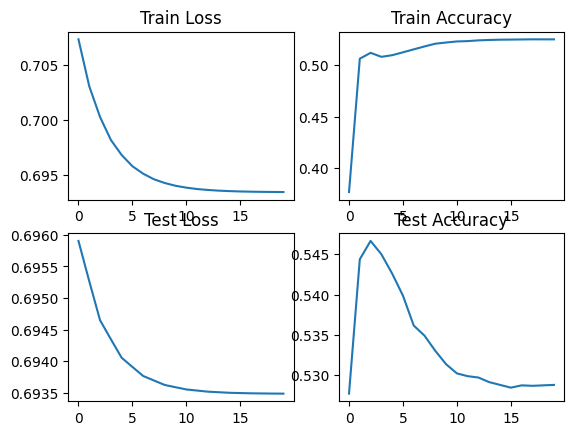

In [ ]:
binary_model = MIDbinary()
binary_model = binary_model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)
train_values = pd.read_csv("data/values_train.csv")
test_values = pd.read_csv("data/values_test.csv")

train_dataset_bin = BinaryDataset(train_values)
test_dataset_bin = BinaryDataset(test_values)
train_dataloader_bin = DataLoader(train_dataset_bin, batch_size=batch_size, shuffle=True)
test_dataloader_bin = DataLoader(test_dataset_bin, batch_size=batch_size, shuffle=True)

results_train = []
results_test = []
num_epochs = 20
max_test = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(binary_model, train_dataloader_bin, optimizer, criterion, device)
    results_train.append([train_loss, train_acc.item()])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(binary_model, test_dataloader_bin, criterion, device)
    results_test.append([test_loss, test_acc.item()])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if( epoch > 0  and (results_train[len(results_train)-1][0] >=  results_train[len(results_train)-2][0])):
        print(results_train[len(results_train)-1], results_train[len(results_train)-2])
        print("Overfitting")
        break
    if epoch % 2 == 0:
        learning_rate = learning_rate/2
        optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)
    if test_acc > max_test:
        max_test = test_acc
        torch.save(binary_model.state_dict(), f"models/binary_model.pt")

torch.save(binary_model.state_dict(), f"models/binary_model_last.pt")

print("Train: ", results_train)
print("Test: ", results_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot([i[0] for i in results_train])
axs[0, 0].set_title("Train Loss")
axs[0, 1].plot([i[1] for i in results_train])
axs[0, 1].set_title("Train Accuracy")
axs[1, 0].plot([i[0] for i in results_test])
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot([i[1] for i in results_test])
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [ ]:
if best_acc1 > best_acc2:
    model = MIDmodel()
    model.load_state_dict(torch.load("models/MIDmodel.pt"))
else:
    model = MIDmodel2()
    model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

binary_model = MIDbinary()
binary_model.load_state_dict(torch.load("models/binary_model.pt"))
binary_model.to(device)
binary_model.eval()

usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, _ = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    binary_output = binary_model(sm)
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = torch.argmax(binary_output).cpu().detach().numpy()
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1

print("Accuracy of the binary model on test set:")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)

100%|██████████| 17512/17512 [04:12<00:00, 69.30it/s]

Accuracy of the binary model on test set:
Useful:  9573
Useful[%]:  54.66537231612608
Useless:  7939
Useless[%]:  45.33462768387391


Support Vector Classifier

In [3]:
# load the values
pred_train = pd.read_csv("data/values_train.csv")
pred_test = pd.read_csv("data/values_test.csv")


pred_train = pred_train.drop("path", axis=1)
pred_test = pred_test.drop("path", axis=1)
pred_train = pred_train.drop("true", axis=1)
pred_test = pred_test.drop("true", axis=1)
pred_test = pred_test.drop("predicted", axis=1)
pred_train = pred_train.drop("predicted", axis=1)

# we need preds_train and preds_test to have 50% of correct = 1 and 50% of correct = 0 to balance the dataset
print("Before balancing:")
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))
print("Test correct = 1: ", len(pred_test[pred_test["correct"] == 1]))
print("Test correct = 0: ", len(pred_test[pred_test["correct"] == 0]))

preds_tmp = pred_train[pred_train["correct"] == 0]
preds_tmp = pd.concat([preds_tmp, pred_train[pred_train["correct"] == 1][:len(preds_tmp)]])
pred_train = preds_tmp
print("\nAfter balancing:")
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))


X_train = pred_train.drop("correct", axis=1)
y_train = pred_train["correct"]
X_test = pred_test.drop("correct", axis=1)
y_test = pred_test["correct"]

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
pickle.dump(clf, open("models/svc.pkl", "wb"))


Before balancing:
Train correct = 1:  24493
Train correct = 0:  5716
Test correct = 1:  9865
Test correct = 0:  7647

After balancing:
Train correct = 1:  5716
Train correct = 0:  5716
Accuracy:  0.5633851073549566


In [ ]:
if best_acc1 > best_acc2:
    model = MIDmodel()
    model.load_state_dict(torch.load("models/MIDmodel.pt"))
else:
    model = MIDmodel2()
    model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

clf = pickle.load(open("models/svc.pkl", 'rb'))

usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, paths = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    sm =sm.cpu().detach().numpy()
    binary_output = clf.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = binary_output[0]
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1


print("Accuracy of the SVC on the test set:")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)
    


100%|██████████| 17512/17512 [04:43<00:00, 61.82it/s]

Accuracy of the SVC on the test set:
Useful:  9866
Useful[%]:  56.33851073549566
Useless:  7646
Useless[%]:  43.66148926450434


Confusion matrix for the DL binary classifier:


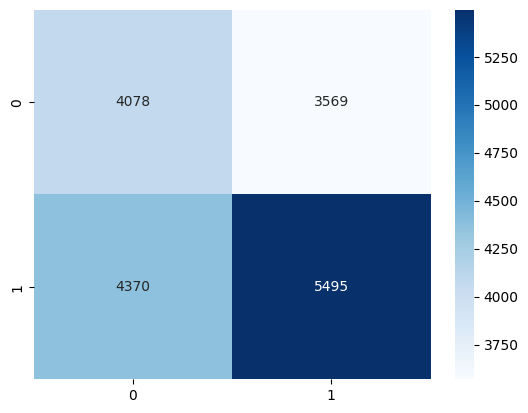

Confusion matrix for the SVC binary classifier:


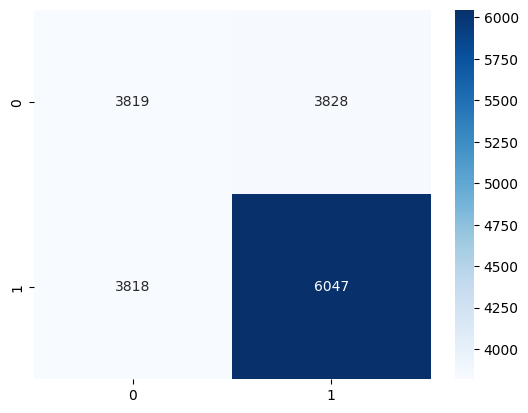

In [ ]:
model = MIDbinary()
model.load_state_dict(torch.load("models/binary_model.pt"))
model.eval()

test_values = pd.read_csv("data/values_test.csv")
test_dataset_bin = BinaryDataset(test_values)

y_true = []
y_pred = []
for i, _ in enumerate(test_dataset_bin):
    sms, label, _ = test_dataset_bin[i]
    sms = sms.unsqueeze(0)
    output = model(sms)
    output = output.detach().numpy()
    output = np.argmax(output)
    y_true.append(label)
    y_pred.append(output)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
print("Confusion matrix for the DL binary classifier:")
plt.show()

binary_classifier = pickle.load(open("models/svc.pkl", "rb"))
y_true = []
y_pred = []
for i, _ in enumerate(test_dataset_bin):
    sms, label, _ = test_dataset_bin[i]
    sms = sms.unsqueeze(0).detach().numpy()
    sms = pd.DataFrame(sms, columns=["sm0", "sm1", "sm2", "sm3"])
    output = binary_classifier.predict(sms)
    output = output[0]
    y_true.append(label)
    y_pred.append(output)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
print("Confusion matrix for the SVC binary classifier:")
plt.show()

# t-SNE to visualize only the correct prediction **ebmbeddingss**

In [15]:
for patient in train_patients:
    print("Number of images for each score for patient", patient)
    result = images_df[images_df["patient_id"] == patient]["score"].value_counts()
    result = result.sort_index()
    print(result)

max_number = 44
selected_df = pd.DataFrame()
for patient in train_patients:
    for score in range(0,4):
        patient_score_df = images_df[(images_df["patient_id"] == patient) & (images_df["score"] == f"{score}")]
        if len(patient_score_df) < max_number:
            selected_df = pd.concat([selected_df, patient_score_df])
        else:
            selected_df = pd.concat([selected_df, patient_score_df.sample(n=max_number, random_state=42)])

print(len(selected_df))
print("Number of images for each score for the selected images")
result = selected_df["score"].value_counts()
result = result.sort_index()
print(result)

paths_df = pd.DataFrame()
for index, row in selected_df.iterrows():
    path = os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png" )
    tmp_df = pd.DataFrame({"path": [path]})
    paths_df = pd.concat([paths_df, tmp_df])

Number of images for each score for patient 1048
0    3159
1    1472
2     336
3    1440
Name: score, dtype: int64
Number of images for each score for patient 1050
0     317
1     427
2     746
3    1270
Name: score, dtype: int64
Number of images for each score for patient 1052
0    1026
1    2248
2    2494
3     492
Name: score, dtype: int64
Number of images for each score for patient 1067
0      75
1     829
2    1111
3    2245
Name: score, dtype: int64
Number of images for each score for patient 1069
0     915
1     522
2     736
3    1212
Name: score, dtype: int64
Number of images for each score for patient 1047
0    543
1    356
2     44
3    208
Name: score, dtype: int64
Number of images for each score for patient 1017
0    1478
1    1388
2    1256
3     625
Name: score, dtype: int64
Number of images for each score for patient 1051
0    375
1    298
2    466
3    100
Name: score, dtype: int64
1408
Number of images for each score for the selected images
0    352
1    352
2    352


In [16]:
for patient in test_patients:
    # print the number of images for each score based on image_df
    print("Number of images for each score for patient", patient)
    result = images_df[images_df["patient_id"] == patient]["score"].value_counts()
    # sort the result by score
    result = result.sort_index()
    print(result)

max_number = 29
selected_df_test = pd.DataFrame()
for patient in test_patients:
    for score in range(0,4):
        # get the images for the patient and score
        patient_score_df = images_df[(images_df["patient_id"] == patient) & (images_df["score"] == f"{score}")]
        # if the number of images is less than 40, select all of them
        if len(patient_score_df) < max_number:
            selected_df_test = pd.concat([selected_df_test, patient_score_df])
        else:
            # select 29 images randomly
            selected_df_test = pd.concat([selected_df_test, patient_score_df.sample(n=max_number, random_state=42)])
print(len(selected_df_test))
# print the number of images for each score based on selected_df
print("Number of images for each score for the selected images")
result = selected_df_test["score"].value_counts()
# sort the result by score
result = result.sort_index()
print(result)

# create a new dataframe using each entry of the selected_df as path
paths_test_df = pd.DataFrame()
for index, row in selected_df_test.iterrows():
    # get the path
    path = os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png" )
    # create a new dataframe with the path
    tmp_df = pd.DataFrame({"path": [path]})
    # add the new dataframe to the values dataframe
    paths_test_df = pd.concat([paths_test_df, tmp_df])

Number of images for each score for patient 1066
0     210
1     911
2    1707
3     677
Name: score, dtype: int64
Number of images for each score for patient 1068
0     217
1     781
2    3458
3    2552
Name: score, dtype: int64
Number of images for each score for patient 1045
0    6198
1      29
2     370
3     402
Name: score, dtype: int64
348
Number of images for each score for the selected images
0    87
1    87
2    87
3    87
Name: score, dtype: int64


## With embeddings

In [ ]:
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

embeddings = []
predictions = []
embeddings_label = []
colors = []
for i in tqdm(range(len(train_dataset))):
    img, label, paths = train_dataset[i]
    if paths not in paths_df["path"].values:
        continue
    embeddings_label.append(label)
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model.get_embeddings(img)
    embeddings.append(output.cpu().detach().numpy())
    prediction = model(img)
    predicted_label = torch.argmax(prediction).cpu().detach().numpy()
    if predicted_label == label:
        predictions.append(1)
        colors.append("green")
    else:
        predictions.append(0)
        colors.append("red")
embeddings = np.array(embeddings)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
np.save("data/embeddings.npy", embeddings)
np.save("data/embeddings_label.npy", embeddings_label)

100%|██████████| 30209/30209 [16:44<00:00, 30.07it/s]


In [ ]:
n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]


iterations = 0
for i in tqdm(range(len(test_dataset))):
    if test_dataset[i][2] not in paths_test_df["path"].values:
        continue
    iterations += 1
    emb = model.get_embeddings(test_dataset[i][0].unsqueeze(0).to(device)).cpu().detach().numpy()
    label = test_dataset[i][1]
    if i == 0:
        np.append(embeddings, emb, axis=0)
    else:
        embeddings[-1] = emb

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
    tsne_results = tsne.fit_transform(embeddings)

    distances = np.linalg.norm(tsne_results - tsne_results[-1], axis=1)
    for j in range(2,n+2):
        nearest_points = np.argsort(distances)[:j]
        nearest_points = np.delete(nearest_points, 0)
        scores = []
        for point in nearest_points:
            scores.append(embeddings_label[point])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)

        if mean_val == label:
            correct_mean[j-1] += 1
        if min_val == label:
            correct_min[j-1] += 1
        if max_val == label:
            correct_max[j-1] += 1
        if median_val == label:
            correct_median[j-1] += 1
        if mode_val == label:
            correct_mode[j-1] += 1

max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"
    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")

100%|██████████| 17512/17512 [08:55<00:00, 32.68it/s] 

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%
With 1 neighbors, the accuracy with mean is 45.40229885057471%
With 1 neighbors, the accuracy with min is 45.40229885057471%
With 1 neighbors, the accuracy with avg is 45.40229885057471%
With 1 neighbors, the accuracy with median is 45.40229885057471%
With 1 neighbors, the accuracy with mode is 45.40229885057471%
With 2 neighbors, the accuracy with mean is 40.229885057471265%
With 2 neighbors, the accuracy with min is 43.96551724137931%
With 2 neighbors, the accuracy with avg is 43.96551724137931%
With 2 neighbors, the accuracy with median is 35.63218390804598%
With 2 neighbors, the accuracy with mode is 43.96551724137931%
With 3 neighbors, the accuracy with mean is 41.66666666666667%
With 3 neighbors, the accuracy with min is 46.264367816091955

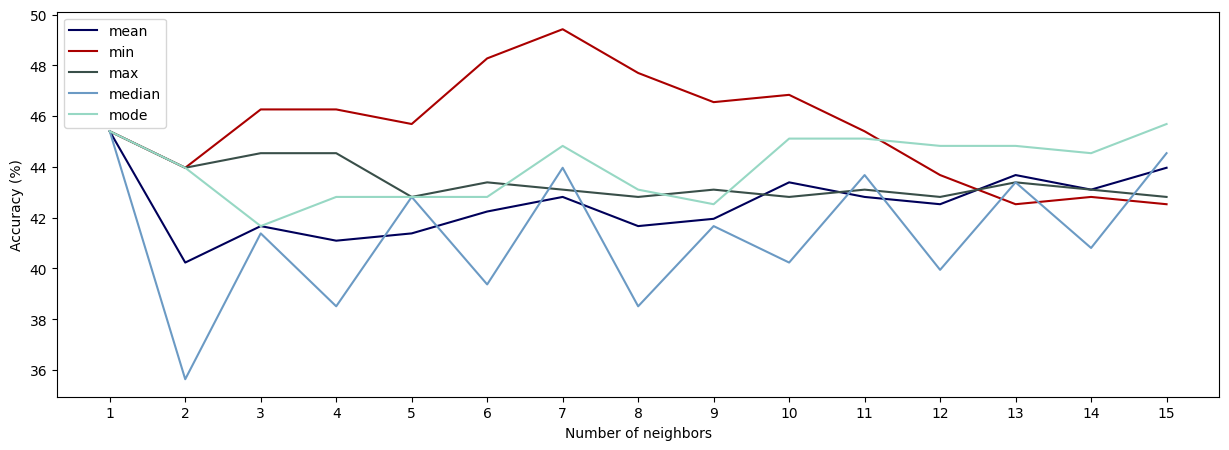

In [ ]:
plt.figure(figsize=(15,5))
colors_val =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color=colors_val[0])
plt.plot(range(1,n+1), new_min[1:], label="min", color="#AA0000")
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[1])
plt.plot(range(1,n+1), new_median[1:], label="median", color=colors_val[2])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color=colors_val[3])
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

## With softmax values

In [73]:

# create the TNSE model (keeping the path information for later)
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct

# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]

colors = ["green" if i == 1 else "red" for i in values["correct"].values]
colors.append("blue")
values_test = pd.read_csv("data/values_test.csv")
values_test = values_test[values_test["path"].isin(paths_test_df["path"].values)]

n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]

iterations = 0
for i in tqdm(range(len(values_test))):
    iterations += 1
    if i == 0:
        # values = values.append(values_test.iloc[i], ignore_index=True)
        values = pd.concat([values, values_test.iloc[i:i+1]], ignore_index=True)
    else:
        values.iloc[len(values)-1] = values_test.iloc[i]
    points = values[["sm0", "sm1", "sm2", "sm3"]].values

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
    tsne_results = tsne.fit_transform(points)

    distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)

    for j in range(2,n+2):
        nearest_points = np.argsort(distances)[:j]
        nearest_points = np.delete(nearest_points, 0)
        
        scores = []
        for k in range(len(nearest_points)):
            scores.append(values.iloc[nearest_points[k]]["true"])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)
        if(mean_val == values_test.iloc[i]["true"]):
            correct_mean[j-1] += 1
        if(min_val == values_test.iloc[i]["true"]):
            correct_min[j-1] += 1
        if(max_val == values_test.iloc[i]["true"]):
            correct_max[j-1] += 1
        if(median_val == values_test.iloc[i]["true"]):
            correct_median[j-1] += 1
        if(mode_val == values_test.iloc[i]["true"]):
            correct_mode[j-1] += 1
    del points
    del tsne
    del tsne_results
    del distances
    gc.collect()
max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"

    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%\n")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")

100%|██████████| 348/348 [06:19<00:00,  1.09s/it]

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%

With 1 neighbors, the accuracy with mean is 48.275862068965516%
With 1 neighbors, the accuracy with min is 48.275862068965516%
With 1 neighbors, the accuracy with avg is 48.275862068965516%
With 1 neighbors, the accuracy with median is 48.275862068965516%
With 1 neighbors, the accuracy with mode is 48.275862068965516%

With 2 neighbors, the accuracy with mean is 47.12643678160919%
With 2 neighbors, the accuracy with min is 47.41379310344828%
With 2 neighbors, the accuracy with avg is 52.29885057471264%
With 2 neighbors, the accuracy with median is 37.06896551724138%
With 2 neighbors, the accuracy with mode is 47.41379310344828%

With 3 neighbors, the accuracy with mean is 52.29885057471264%
With 3 neighbors, the accuracy with min is 44.82758620

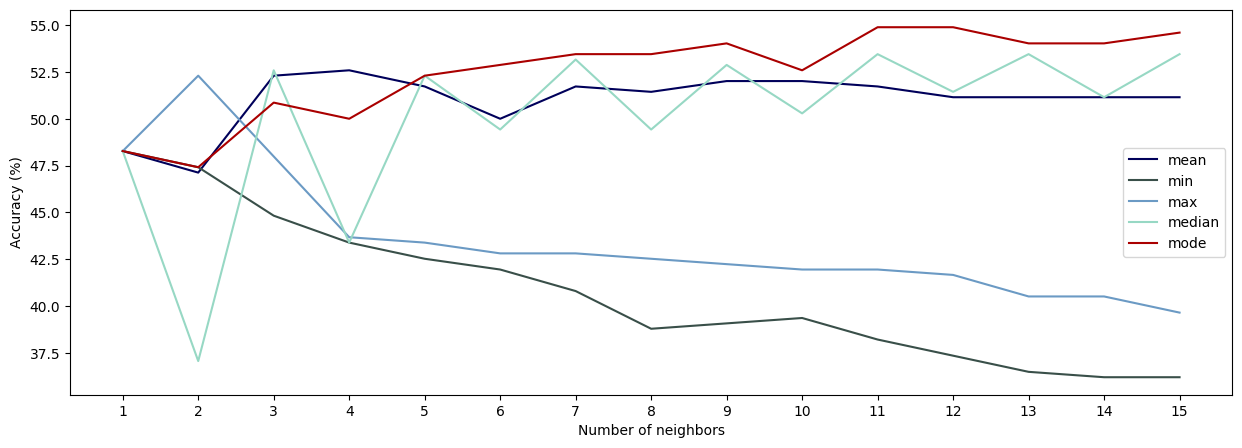

In [74]:
# plot correct_mean, correct_min, correct_max over the number of neighbors
plt.figure(figsize=(15,5))
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color=colors_val[0])
plt.plot(range(1,n+1), new_min[1:], label="min", color=colors_val[1])
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[2])
plt.plot(range(1,n+1), new_median[1:], label="median",  color=colors_val[3])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color="#AA0000")
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")	
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

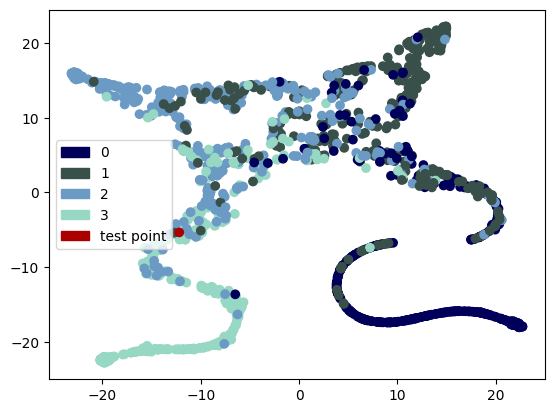

True label of test frame:  3
Predicted label of test frame:  3


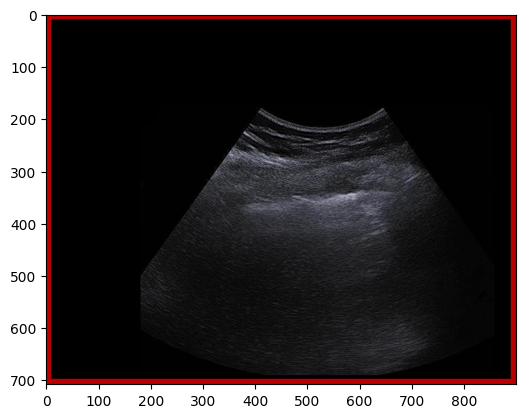

Scores mode: 3


In [72]:
# visual example behavior-wise

# create the TNSE model (keeping the path information for later)
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
n = 11
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
colors = []
for path in values["path"].values:
    if values[values["path"] == path]["true"].values[0] == 0:
        colors.append(colors_val[0])
    elif values[values["path"] == path]["true"].values[0] == 1:
        colors.append(colors_val[1])
    elif values[values["path"] == path]["true"].values[0] == 2:
        colors.append(colors_val[2])
    else:
        colors.append(colors_val[3])

colors.append("#AA0000")
values_test = pd.read_csv("data/values_test.csv")
values_test = values_test[values_test["path"].isin(paths_test_df["path"].values)]
random_index = np.random.randint(0, len(values_test))
# random_query = values_test.iloc[random_index]
# values = pd.concat([values, random_query], ignore_index=True)
values = values.append(values_test.iloc[random_index], ignore_index=True)
points = values[["sm0", "sm1", "sm2", "sm3"]].values
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
tsne_results = tsne.fit_transform(points)

distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)

nearest_points_number = n+1
nearest_points = np.argsort(distances)[:nearest_points_number]
nearest_points = np.delete(nearest_points, 0)


plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors)
blue_patch = mpatches.Patch(color=colors_val[0] , label='0')
orange_patch = mpatches.Patch(color=colors_val[1], label='1')
green_patch = mpatches.Patch(color=colors_val[2], label='2')
violet_patch = mpatches.Patch(color=colors_val[3], label='3')
red_patch = mpatches.Patch(color="#AA0000", label='test point')
plt.legend(handles=[blue_patch, orange_patch, green_patch, violet_patch, red_patch])
plt.show()

print("True label of test frame: ", test_values.iloc[random_index]["true"])
print("Predicted label of test frame: ", test_values.iloc[random_index]["predicted"])
image = cv2.imread(test_values.iloc[random_index]["path"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[186, 0, 0])
plt.imshow(image)
plt.show()

scores = []
for i in range(len(nearest_points)):
    # print also the true and predicted label
    scores.append(values.iloc[np.argsort(distances)[i]]["true"])
    # print(f"True label of the {i+1}° nearest image:", values.iloc[np.argsort(distances)[i]]["true"])
    # image = cv2.imread(values.iloc[np.argsort(distances)[i]]["path"])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()
print("Scores mode:", max(set(scores), key=scores.count))


## With raw images

In [54]:
gc.enable()

values = pd.read_csv("data/values_train.csv")

images = []
colors = []
for path in values["path"].values:
    # check if path in paths_df["path"].values
    if path not in paths_df["path"].values:
        continue
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256)) # Resize the image to a fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    image = image.astype('float32') / 255.0 # Normalize the pixel values
    images.append(image)
    if values[values["path"] == path]["true"].values[0] == 1:
        colors.append("green")
    else:
        colors.append("red")
    del image

n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]
test_values = pd.read_csv("data/values_test.csv")

test_values = test_values[test_values["path"].isin(paths_test_df["path"].values)]
iterations = len(test_values["path"].values)
for index in tqdm(range(iterations)):
    new_image = cv2.imread(test_values.iloc[index]["path"])
    new_image = cv2.resize(new_image, (256, 256))
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    # new_image = new_image.astype('float32') / 255.0 # Normalize the pixel values
    if(index == 0):
        images.append(new_image)
        colors.append("blue")
        images = np.array(images)
        images_flattened = images.reshape(images.shape[0], -1)
    else:
        new_image = np.array(new_image)
        new_image = new_image.reshape(1, -1)
        images_flattened[len(images_flattened)-1] = new_image

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
    tsne_results = tsne.fit_transform(images_flattened)

    distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
    
    for nearest_points_number in range(2,n+2):
        nearest_points = np.argsort(distances)[:nearest_points_number]
        nearest_points = np.delete(nearest_points, 0)
        scores = []
        for i in range(len(nearest_points)):
            scores.append(values.iloc[np.argsort(distances)[i]]["true"])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)
        if(mean_val == int(test_values.iloc[index]["true"])):
            correct_mean[nearest_points_number-1] += 1
        if(min_val == int(test_values.iloc[index]["true"])):
            correct_min[nearest_points_number-1] += 1
        if(max_val == int(test_values.iloc[index]["true"])):
            correct_max[nearest_points_number-1] += 1
        if(median_val == int(test_values.iloc[index]["true"])):
            correct_median[nearest_points_number-1] += 1
        if(mode_val == int(test_values.iloc[index]["true"])):
            correct_mode[nearest_points_number-1] += 1
    if(index == 0):
        del images
    del new_image
    del tsne
    del scores
    del nearest_points
    gc.collect()

max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"
    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%\n")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")


100%|██████████| 348/348 [1:18:09<00:00, 13.47s/it]

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%

With 1 neighbors, the accuracy with mean is 25.0%
With 1 neighbors, the accuracy with min is 25.0%
With 1 neighbors, the accuracy with avg is 25.0%
With 1 neighbors, the accuracy with median is 25.0%
With 1 neighbors, the accuracy with mode is 25.0%

With 2 neighbors, the accuracy with mean is 26.72413793103448%
With 2 neighbors, the accuracy with min is 25.0%
With 2 neighbors, the accuracy with avg is 18.103448275862068%
With 2 neighbors, the accuracy with median is 21.551724137931032%
With 2 neighbors, the accuracy with mode is 25.0%

With 3 neighbors, the accuracy with mean is 26.14942528735632%
With 3 neighbors, the accuracy with min is 25.0%
With 3 neighbors, the accuracy with avg is 18.103448275862068%
With 3 neighbors, the accuracy with 

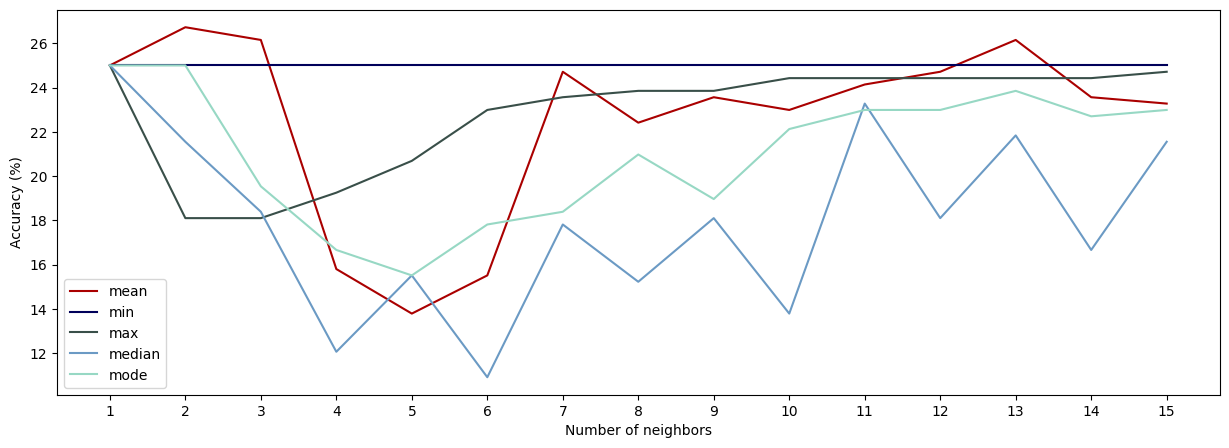

In [71]:
plt.figure(figsize=(15,5))
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color="#AA0000")
plt.plot(range(1,n+1), new_min[1:], label="min", color=colors_val[0])
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[1])
plt.plot(range(1,n+1), new_median[1:], label="median", color=colors_val[2])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color=colors_val[3])
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

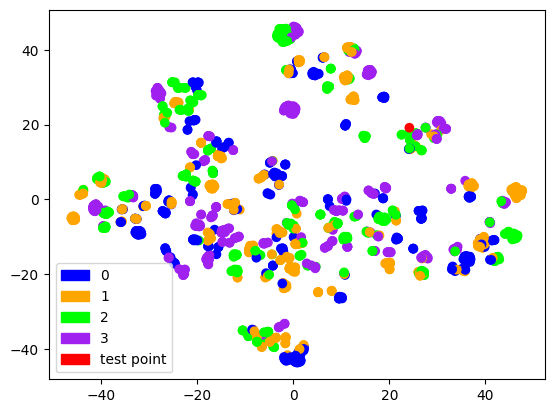

True label of test frame:  2
Predicted label of test frame:  2


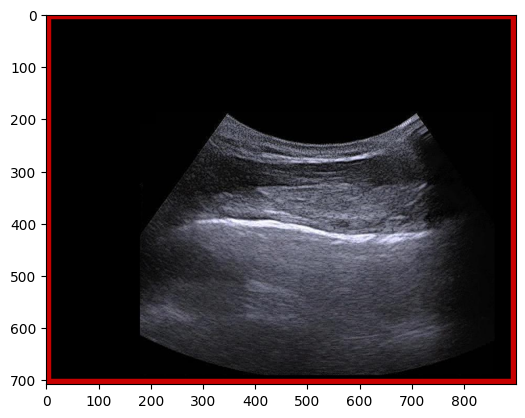

Due to the 41 images required, we don't print them
Average score: 1


In [56]:
# Load the images and normalize them
images = []
colors = []
values = pd.read_csv("data/values_train.csv")
for path in values["path"].values:
    if path not in paths_df["path"].values:
        continue
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256)) # Resize the image to a fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    image = image.astype('float32') / 255.0 # Normalize the pixel values
    images.append(image)
    # score 0 blue, score 1 orange, score 2 green and score 3 purple
    if values[values["path"] == path]["true"].values[0] == 0:
        colors.append("#0000FFFF")
    elif values[values["path"] == path]["true"].values[0] == 1:
        colors.append("#FFA500FF")
    elif values[values["path"] == path]["true"].values[0] == 2:
        colors.append("#00FF00FF")
    else:
        colors.append("#A020F0FF")
    
test_values = pd.read_csv("data/values_test.csv")
test_values = test_values[test_values["path"].isin(paths_test_df["path"].values)]
random_index = np.random.randint(0, len(test_values))
new_image = cv2.imread(test_values.iloc[random_index]["path"])
new_image = cv2.resize(new_image, (256, 256)) # Resize the image to a fixed size
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
new_image = new_image.astype('float32') / 255.0 # Normalize the pixel values
images.append(new_image)
colors.append("red")
images = np.array(images)

# Flatten the images
images_flattened = images.reshape(images.shape[0], -1)

# Fit the t-SNE model on the flattened images
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(images_flattened)

# Plot the t-SNE embeddings
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors)

blue_patch = mpatches.Patch(color='#0000FF', label='0')
orange_patch = mpatches.Patch(color='#FFA500', label='1')
green_patch = mpatches.Patch(color='#00FF00', label='2')
violet_patch = mpatches.Patch(color='#A020F0', label='3')
red_patch = mpatches.Patch(color='#AA0000', label='test point')
plt.legend(handles=[blue_patch, orange_patch, green_patch, violet_patch, red_patch])
plt.show()

# print true and predicted label of the image
print("True label of test frame: ", test_values.iloc[random_index]["true"])
print("Predicted label of test frame: ", test_values.iloc[random_index]["predicted"])
# print the selected image
image = cv2.imread(test_values.iloc[random_index]["path"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# add the border
image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[200, 0, 0])
plt.imshow(image)
plt.show()

# find the two closest images to the last one in the images array
distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
nearest_points_number = 42
nearest_points = np.argsort(distances)[:nearest_points_number]
nearest_points = np.delete(nearest_points, 0)
scores = []
for i in range(len(nearest_points)):
    # print also the true and predicted label
    # print(f"True label of the {i+1}° nearest image:", values.iloc[np.argsort(distances)[i]]["true"])
    scores.append(values.iloc[np.argsort(distances)[i]]["true"])
    # image = cv2.imread(values.iloc[np.argsort(distances)[i]]["path"])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()
print("Due to the 41 images required, we don't print them")
print("Average score:", round(np.mean(scores)))

# NEAR-DUPLICATE IMAGE SEARCH

In [57]:
def getPath(row):
    return os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")

In [59]:
from annoy import AnnoyIndex

# Load pre-trained model
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

# Load the dataset
root_dir = "images/"
# train_df is the image_df only where the path is in the paths_df
train_df = pd.DataFrame(columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
test_df = pd.DataFrame(columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
for i in range(len(images_df)):
    if getPath(images_df.iloc[i]) in paths_df["path"].values:
        train_df = pd.concat([train_df, images_df.iloc[i]])
    if getPath(images_df.iloc[i]) in paths_test_df["path"].values:
        test_df = pd.concat([test_df, images_df.iloc[i]])
   

train_dataset = ImageDataset(root_dir, train_patients, train_df, transform=None)
test_dataset = ImageDataset(root_dir, test_patients, test_df, transform=None)

features = []
for i in tqdm(range(len(train_dataset))):
    image, _, _ = train_dataset[i]
    feature = model.get_embeddings(image.unsqueeze(0).to(device))
    features.append(feature)
features = np.array(features)

# Build an AnnoyIndex
n_trees = 10  # The number of trees in the index
n_features = features.shape[0]
annoy_index = AnnoyIndex(n_features, 'angular')
for i, feature in tqdm(enumerate(features)):
    annoy_index.add_item(i, feature)
annoy_index.build(n_trees)

# Define a function to search for near-duplicate images
def search_near_duplicates(image, threshold=0.5):
    query_feature = model.get_embeddings(image.unsqueeze(0).to(device))
    indices, distances = annoy_index.get_nns_by_vector(query_feature, len(train_dataset), include_distances=True)
    near_duplicates = []
    for i, index in enumerate(indices):
        if distances[i] > threshold:
            break
        _, label, path = train_dataset[index]
        near_duplicates.append((path, label, distances[i]))
    return near_duplicates

def evaluate_model(test_dataset, threshold=0.5, k=5):
    total = 0
    correct_mean = 0
    correct_min = 0
    correct_max = 0
    correct_median = 0
    correct_mode = 0
    for i, _ in tqdm(enumerate(test_dataset)):
        image, label, _ = test_dataset[i]
        near_duplicates = search_near_duplicates(image, threshold=threshold)[:k]
        if len(near_duplicates) == 0:
            continue
        scores = [x[1] for x in near_duplicates]
        avg_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        median_score = np.median(scores)
        mode_score = max(set(scores), key=scores.count)
        if label == round(avg_score):
            correct_mean += 1
        if label == round(min_score):
            correct_min += 1
        if label == round(max_score):
            correct_max += 1
        if label == round(median_score):
            correct_median += 1
        if label == round(mode_score):
            correct_mode += 1
        total += 1

    print(f"Correct mean: {correct_mean}/{total} ({correct_mean/total*100:.4f}%)")
    print(f"Correct min: {correct_min}/{total} ({correct_min/total*100:.4f}%)")
    print(f"Correct max: {correct_max}/{total} ({correct_max/total*100:.4f}%)")
    print(f"Correct median: {correct_median}/{total} ({correct_median/total*100:.4f}%)")
    print(f"Correct mode: {correct_mode}/{total} ({correct_mode/total*100:.4f}%)")
    best_function_val = max([correct_mean, correct_min, correct_max, correct_median, correct_mode])
    best_function_name = ""
    if best_function_val == correct_mean:
        best_function_name = "mean"
    elif best_function_val == correct_min:
        best_function_name = "min"
    elif best_function_val == correct_max:
        best_function_name = "max"
    elif best_function_val == correct_median:
        best_function_name = "median"
    elif best_function_val == correct_mode:
        best_function_name = "mode"
    return best_function_name, best_function_val/total

name, accuracy = evaluate_model(test_dataset, train_dataset)
print(f"Best function: {name} with accuracy {accuracy*100:.4f}%")

0it [00:00, ?it/s]


TypeError: 'tuple' object cannot be interpreted as an integer

FINAL MODEL

In [12]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
class MIDfinal2(nn.Module):
    def __init__(self, values_train):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        # load the binary classifier from binary_model_17.pt
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        # self.binary_classifier = pickle.load(open("svc.pkl", "rb"))
        self.values_train = values_train

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        binary_output = self.binary_classifier(predicted_label)
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        # if the binary classifier says FALSE, then we do t-SNE
        if predicted_binary == 0:
            # get the t-SNE output
            res = predicted_label.detach().numpy()
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            # values_train = pd.concat([self.values_train, res], axis=1, ignore_index=True)
            values_train = self.values_train.append(res, ignore_index=True)
            points = values_train[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            return mode_val
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        return res


100%|██████████| 17512/17512 [2:38:10<00:00,  1.85it/s]  

Accuracy: 9632/17512 (55.0023%)


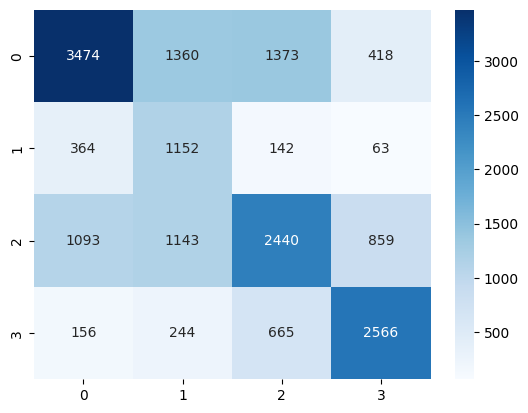

In [45]:
# create the model and test on the test dataset
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
model = MIDfinal2(values)
model.eval()
# test the model
# test_dataset = ImageDataset("images/", test_patients, images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

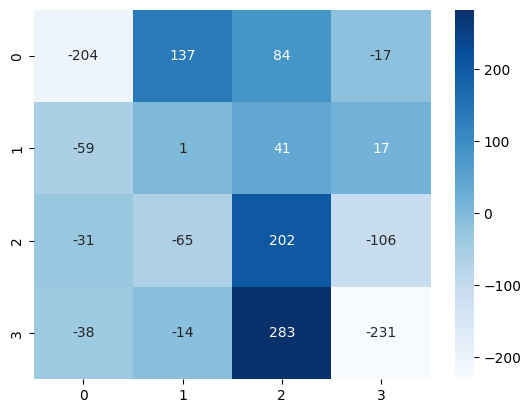

In [46]:
cm1 = [[3678, 1223,1289,435],
       [423, 1151, 101, 46],
       [1124, 1208, 2238, 965],
       [194, 258, 382, 2797]]

cm2 =[[3474, 1360, 1373, 418],
      [364, 1152, 142, 63],
      [1093, 1143, 2440, 859],
      [156, 244, 665, 2566]]

diff = np.array(cm2) - np.array(cm1)
sns.heatmap(diff, annot=True, fmt="d", cmap="Blues")
plt.show()

In [49]:
class MIDfinal2(nn.Module):
    def __init__(self, values_train):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        # load the binary classifier from binary_model_17.pt
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        # self.binary_classifier = pickle.load(open("svc.pkl", "rb"))
        self.values_train = values_train

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        label_value = torch.argmax(res).detach().numpy()
        binary_output = self.binary_classifier(predicted_label)
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        # if the binary classifier says FALSE, then we do t-SNE
        if predicted_binary == 0 and label_value != 0 and label_value != 3:
            # get the t-SNE output
            res = predicted_label.detach().numpy()
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            # values_train = pd.concat([self.values_train, res], axis=1, ignore_index=True)
            values_train = self.values_train.append(res, ignore_index=True)
            points = values_train[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            return mode_val
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        return res

100%|██████████| 17512/17512 [1:05:43<00:00,  4.44it/s]

Accuracy: 9892/17512 (56.4870%)


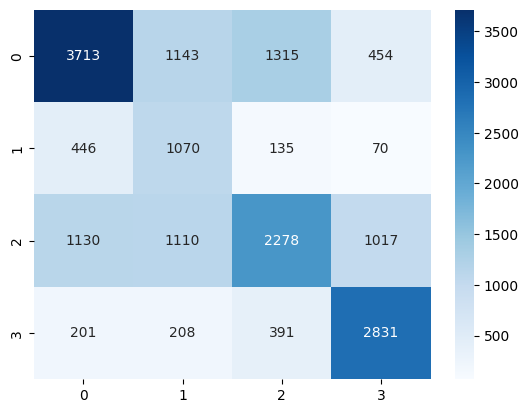

In [50]:
# create the model and test on the test dataset
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
model = MIDfinal2(values)
model.eval()
# test the model
# test_dataset = ImageDataset("images/", test_patients, images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()